In [1]:
import numpy as np
import pandas as pd

In [2]:
#!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
#!unzip ml-100k.zip

In [3]:
cd ml-100k/

C:\Users\Xoejang\Documents\tekweb2\Praktikum-1\ml-100k


In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 0A1D-E648

 Directory of C:\Users\Xoejang\Documents\tekweb2\Praktikum-1\ml-100k

01/30/2016  03:26 AM    <DIR>          .
07/21/2022  10:51 PM    <DIR>          ..
07/20/2000  04:09 AM               716 allbut.pl
07/20/2000  04:09 AM               643 mku.sh
01/30/2016  03:26 AM             6,750 README
07/20/2000  04:09 AM         1,979,173 u.data
07/20/2000  04:09 AM               202 u.genre
07/20/2000  04:09 AM                36 u.info
07/20/2000  04:09 AM           236,344 u.item
07/20/2000  04:09 AM               193 u.occupation
07/20/2000  04:09 AM            22,628 u.user
03/09/2001  01:33 AM         1,586,544 u1.base
03/09/2001  01:32 AM           392,629 u1.test
03/09/2001  01:33 AM         1,583,948 u2.base
03/09/2001  01:33 AM           395,225 u2.test
03/09/2001  01:33 AM         1,582,546 u3.base
03/09/2001  01:33 AM           396,627 u3.test
03/09/2001  01:33 AM         1,581,878 u4.base
03/09/2001  01:33 AM     

In [5]:
!head u.data
!echo # line break
!wc -l u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013
# line break
100000 u.data


In [6]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print (str(n_users) + 'users')
print (str(n_items) + 'items')

943users
1682items


In [8]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [9]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [10]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 6.30%


In [11]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [12]:
train, test = train_test_split(ratings)

In [13]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in xrange(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [14]:
#%timeit slow_user_similarity(train)

In [15]:
%timeit fast_similarity(train, kind='user')

56.7 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[1.         0.4022432  0.32132624 0.45208294]
 [0.4022432  1.         0.26821587 0.47522365]
 [0.32132624 0.26821587 1.         0.31706622]
 [0.45208294 0.47522365 0.31706622 1.        ]]


In [17]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [18]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

34 s ± 7.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

69.6 ms ± 7.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

In [21]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.492616149441234
Item-based CF MSE: 11.579211249623285


In [22]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [23]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print (f'Top-k User-based CF MSE: {get_mse(pred, test)}')

pred = predict_topk(train, item_similarity, kind='item', k=40)
print (f'Top-k Item-based CF MSE: {get_mse(pred, test)}')

C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))


Top-k User-based CF MSE: 6.582608760657961


C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T)
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))


Top-k Item-based CF MSE: 7.7412424092296686


In [24]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/1166821206.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

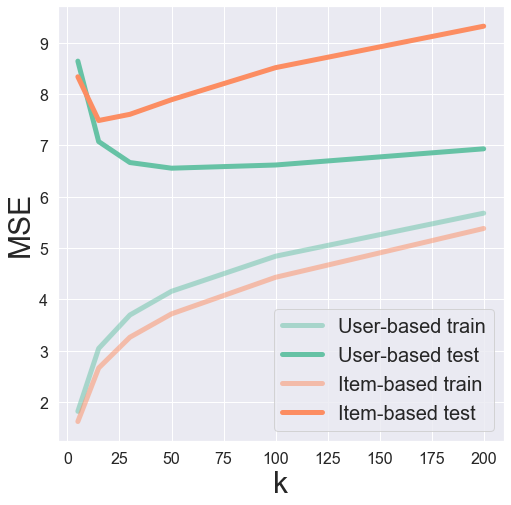

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [26]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [27]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print (f'Bias-subtracted User-based CF MSE: {get_mse(user_pred, test)}')

item_pred = predict_nobias(train, item_similarity, kind='item')
print (f'Bias-subtracted Item-based CF MSE: {get_mse(item_pred, test)}')

Bias-subtracted User-based CF MSE: 8.77514135467254
Bias-subtracted Item-based CF MSE: 9.779556438501158


In [28]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [29]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
C:\Users\Xoejang\AppData\Local\Temp/ipykernel_2528/828948326.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

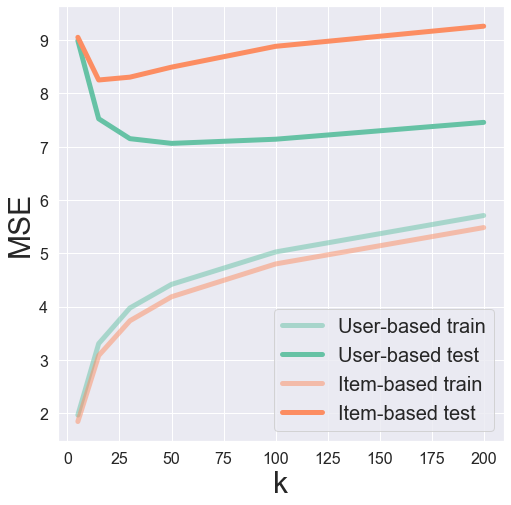

In [30]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [31]:
!head -5 u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


In [32]:
import requests
import json

response = requests.get('https://www.imdb.com/title/tt0114709/')
print (response.url.split('/')[-2])

tt0114709


In [33]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get('https://www.imdb.com/title/tt0114709/')
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [34]:
from IPython.display import Image
from IPython.display import display

toy_story = 'https://www.imdb.com/title/tt0114709/'
Image(url=get_poster(toy_story, base_url))

In [35]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [36]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)

In [37]:
display(*posters)

In [38]:
idx = 1 # GoldenEye
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [39]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get('https://www.imdb.com/title/tt0113189/')
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [40]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [41]:
idx = 1 # GoldenEye
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [42]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get('https://www.imdb.com/title/tt0117110/')
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [43]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [44]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [45]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get('https://www.imdb.com/title/tt0112508/')
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '5379c85bb32618a1d97ef0eaefe7aeed'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [46]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [47]:
idx = 40 # Billy Madison
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [48]:
from sklearn.metrics import pairwise_distances
# Convert from distance to similarity
item_correlation = 1 - pairwise_distances(train.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0.

In [49]:
idx = 0 # Toy Story
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)